In [4]:
# Print all column names to identify the correct target variable
print(data.columns)


Index(['beds', 'baths', 'size', 'lot_size', 'zip_code', 'price'], dtype='object')


In [13]:
print(X_train.shape)
print(y_train.shape)


(1328, 0)
(1328, 6)


In [14]:
# Check for non-numeric types
print(X_train.dtypes)
print(y_train.dtypes)

# Check for NaN or infinite values
print(X_train.isnull().sum())
print(y_train.isnull().sum())

Series([], dtype: object)
beds          int64
baths       float64
size        float64
lot_size    float64
zip_code      int64
price       float64
dtype: object
Series([], dtype: float64)
beds        0
baths       0
size        0
lot_size    0
zip_code    0
price       0
dtype: int64


In [76]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

# Load your dataset
df = pd.read_csv('D:\\AI PROJECT\\train_clean.csv')  # Adjust the path to your dataset

# Adding a new feature: interaction term
df['beds_baths'] = df['beds'] * df['baths']

# Transforming a feature: taking the log of size
df['log_size'] = np.log(df['size'])

# Now, include these new features in your model
features = ['beds', 'baths', 'size', 'lot_size', 'zip_code', 'beds_baths', 'log_size']

# Prepare features and target variables
X = df[features]
y = df[target]

# Scaling features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Convert scaled features back to DataFrame
X_scaled_df = pd.DataFrame(X_scaled, columns=features)

# Splitting data into training and testing sets
X_train_scaled, X_test_scaled, y_train, y_test = train_test_split(X_scaled_df, y, test_size=0.2, random_state=42)

# Add a constant for the intercept to both training and testing sets
X_train_scaled_const = sm.add_constant(X_train_scaled)
X_test_scaled_const = sm.add_constant(X_test_scaled)

# Reset indices to ensure alignment
X_train_scaled_const.reset_index(drop=True, inplace=True)
y_train.reset_index(drop=True, inplace=True)
X_test_scaled_const.reset_index(drop=True, inplace=True)
y_test.reset_index(drop=True, inplace=True)

# Fit the GLM
model_glm = sm.GLM(y_train, X_train_scaled_const, family=sm.families.Gaussian()).fit()

# Display the model summary to inspect coefficients and p-values
print(model_glm.summary())

# Identifying impactful features based on the magnitude of coefficients and their p-values
print("\nFeature Coefficients and P-values:")
coefficients = model_glm.params
p_values = model_glm.pvalues
impactful_features = pd.DataFrame({'Coefficient': coefficients, 'P-value': p_values})
print(impactful_features.sort_values(by='P-value'))

# Predict and evaluate
y_pred = model_glm.predict(X_test_scaled_const)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

# Display the MSE and R^2 score
print(f"\nGLM - Mean Squared Error (MSE): {mse}")
print(f"GLM - R^2 Score: {r2}")


                 Generalized Linear Model Regression Results                  
Dep. Variable:                  price   No. Observations:                 1328
Model:                            GLM   Df Residuals:                     1320
Model Family:                Gaussian   Df Model:                            7
Link Function:               Identity   Scale:                      5.7715e+11
Method:                          IRLS   Log-Likelihood:                -19862.
Date:                Sat, 02 Mar 2024   Deviance:                   7.6184e+14
Time:                        01:55:08   Pearson chi2:                 7.62e+14
No. Iterations:                     3   Pseudo R-squ. (CS):             0.2880
Covariance Type:            nonrobust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        1.03e+06   2.09e+04     49.361      0.0

In [66]:
# Consider removing 'lot_size' and adding an interaction term between 'size' and 'baths'
X_train_refined = X_train_scaled_df.drop(['lot_size'], axis=1)
X_train_refined['size_baths_interaction'] = X_train_refined['size'] * X_train_refined['baths']

X_test_refined = X_test_scaled_df.drop(['lot_size'], axis=1)
X_test_refined['size_baths_interaction'] = X_test_refined['size'] * X_test_refined['baths']

# Add constant for GLM
X_train_refined_const = sm.add_constant(X_train_refined)
X_test_refined_const = sm.add_constant(X_test_refined)

# Fit the GLM with the refined features
model_glm_refined = sm.GLM(y_train, X_train_refined_const, family=sm.families.Gaussian()).fit()

# Display the summary to inspect coefficients of the refined model
print(model_glm_refined.summary())

# Predict and evaluate the refined model
y_pred_refined = model_glm_refined.predict(X_test_refined_const)
mse_refined = mean_squared_error(y_test, y_pred_refined)
r2_refined = r2_score(y_test, y_pred_refined)

print(f"\nRefined GLM - Mean Squared Error (MSE): {mse_refined}")
print(f"Refined GLM - R^2 Score: {r2_refined}")


                 Generalized Linear Model Regression Results                  
Dep. Variable:                  price   No. Observations:                 1328
Model:                            GLM   Df Residuals:                     1322
Model Family:                Gaussian   Df Model:                            5
Link Function:               Identity   Scale:                      5.8212e+11
Method:                          IRLS   Log-Likelihood:                -19869.
Date:                Sat, 02 Mar 2024   Deviance:                   7.6957e+14
Time:                        01:36:45   Pearson chi2:                 7.70e+14
No. Iterations:                     3   Pseudo R-squ. (CS):             0.2787
Covariance Type:            nonrobust                                         
                             coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------
const                   1.00

In [77]:
# Select only 'size', 'beds', and 'zip_code' for the refined model
X_train_selected = X_train_scaled_df[['size', 'beds', 'zip_code]]
X_test_selected = X_test_scaled_df[['size', 'beds', 'zip_code']]

# Add a constant for the intercept
X_train_selected_const = sm.add_constant(X_train_selected)
X_test_selected_const = sm.add_constant(X_test_selected)

# Fit the GLM with the selected features
model_glm_selected = sm.GLM(y_train, X_train_selected_const, family=sm.families.Gaussian()).fit()

# Display the summary to inspect coefficients of the selected feature model
print(model_glm_selected.summary())

# Predict and evaluate the selected feature model
y_pred_selected = model_glm_selected.predict(X_test_selected_const)
mse_selected = mean_squared_error(y_test, y_pred_selected)
r2_selected = r2_score(y_test, y_pred_selected)

print(f"\nSelected Features GLM - Mean Squared Error (MSE): {mse_selected}")
print(f"Selected Features GLM - R^2 Score: {r2_selected}")


                 Generalized Linear Model Regression Results                  
Dep. Variable:                  price   No. Observations:                 1328
Model:                            GLM   Df Residuals:                     1326
Model Family:                Gaussian   Df Model:                            1
Link Function:               Identity   Scale:                      7.0484e+11
Method:                          IRLS   Log-Likelihood:                -19998.
Date:                Sat, 02 Mar 2024   Deviance:                   9.3461e+14
Time:                        01:57:19   Pearson chi2:                 9.35e+14
No. Iterations:                     3   Pseudo R-squ. (CS):            0.08926
Covariance Type:            nonrobust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       1.028e+06    2.3e+04     44.617      0.0

In [70]:
# Select only 'size' and 'zip_code' for the even more refined model
X_train_refined = X_train_scaled_df[['size']]
X_test_refined = X_test_scaled_df[['size']]

# Add a constant for the intercept
X_train_refined_const = sm.add_constant(X_train_refined)
X_test_refined_const = sm.add_constant(X_test_refined)

# Fit the GLM with the refined features
model_glm_refined = sm.GLM(y_train, X_train_refined_const, family=sm.families.Gaussian()).fit()

# Display the summary to inspect coefficients of the refined model
print(model_glm_refined.summary())

# Predict and evaluate the refined model
y_pred_refined = model_glm_refined.predict(X_test_refined_const)
mse_refined = mean_squared_error(y_test, y_pred_refined)
r2_refined = r2_score(y_test, y_pred_refined)

print(f"\nRefined GLM without 'beds' - Mean Squared Error (MSE): {mse_refined}")
print(f"Refined GLM without 'beds' - R^2 Score: {r2_refined}")


                 Generalized Linear Model Regression Results                  
Dep. Variable:                  price   No. Observations:                 1328
Model:                            GLM   Df Residuals:                     1326
Model Family:                Gaussian   Df Model:                            1
Link Function:               Identity   Scale:                      5.9821e+11
Method:                          IRLS   Log-Likelihood:                -19889.
Date:                Sat, 02 Mar 2024   Deviance:                   7.9322e+14
Time:                        01:40:39   Pearson chi2:                 7.93e+14
No. Iterations:                     3   Pseudo R-squ. (CS):             0.2503
Covariance Type:            nonrobust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       1.029e+06   2.12e+04     48.482      0.0

In [86]:
# Assuming df is your loaded DataFrame
# Splitting data into train and test sets with 'price' as the target
X = df[['size','beds','baths']]  # Selecting only 'size' and 'zip_code' for the model
y = df['price']  # Explicitly setting 'price' as the target

# Scaling the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Convert scaled features back to DataFrame for compatibility with statsmodels
X_scaled_df = pd.DataFrame(X_scaled, columns=['size','beds','baths'])

# Splitting the scaled data into training and testing sets
X_train_scaled, X_test_scaled, y_train, y_test = train_test_split(X_scaled_df, y, test_size=0.2, random_state=42)

# Add a constant for the intercept to both training and testing sets
X_train_scaled_const = sm.add_constant(X_train_scaled)
X_test_scaled_const = sm.add_constant(X_test_scaled)

# Fit the GLM with the selected features
model_glm_refined = sm.GLM(y_train, X_train_scaled_const, family=sm.families.Gaussian()).fit()

# Display the summary to inspect coefficients of the refined model
print(model_glm_refined.summary())

# Predict and evaluate the refined model
y_pred_refined = model_glm_refined.predict(X_test_scaled_const)
mse_refined = mean_squared_error(y_test, y_pred_refined)
r2_refined = r2_score(y_test, y_pred_refined)

print(f"\nRefined GLM  - Mean Squared Error (MSE): {mse_refined}")
print(f"Refined GLM  - R^2 Score: {r2_refined}")


                 Generalized Linear Model Regression Results                  
Dep. Variable:                  price   No. Observations:                 1328
Model:                            GLM   Df Residuals:                     1324
Model Family:                Gaussian   Df Model:                            3
Link Function:               Identity   Scale:                      5.9059e+11
Method:                          IRLS   Log-Likelihood:                -19880.
Date:                Sat, 02 Mar 2024   Deviance:                   7.8195e+14
Time:                        02:01:44   Pearson chi2:                 7.82e+14
No. Iterations:                     3   Pseudo R-squ. (CS):             0.2638
Covariance Type:            nonrobust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        1.03e+06   2.11e+04     48.843      0.0

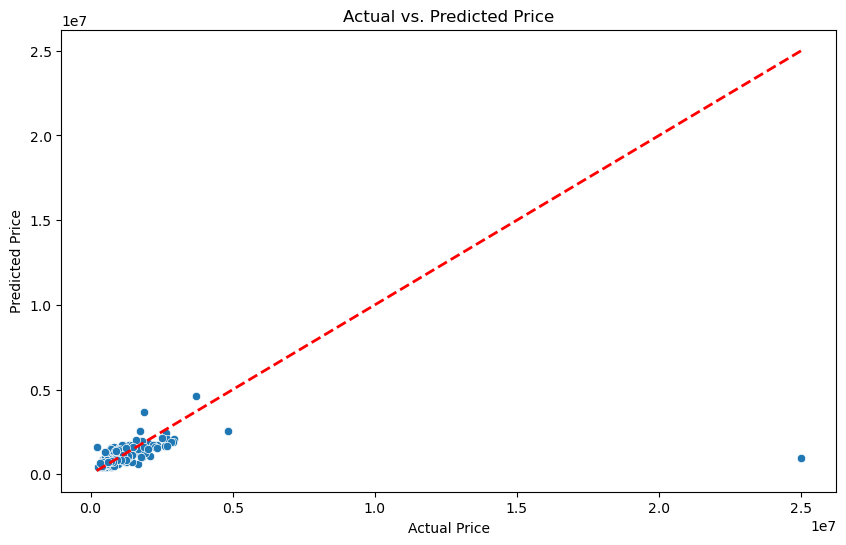

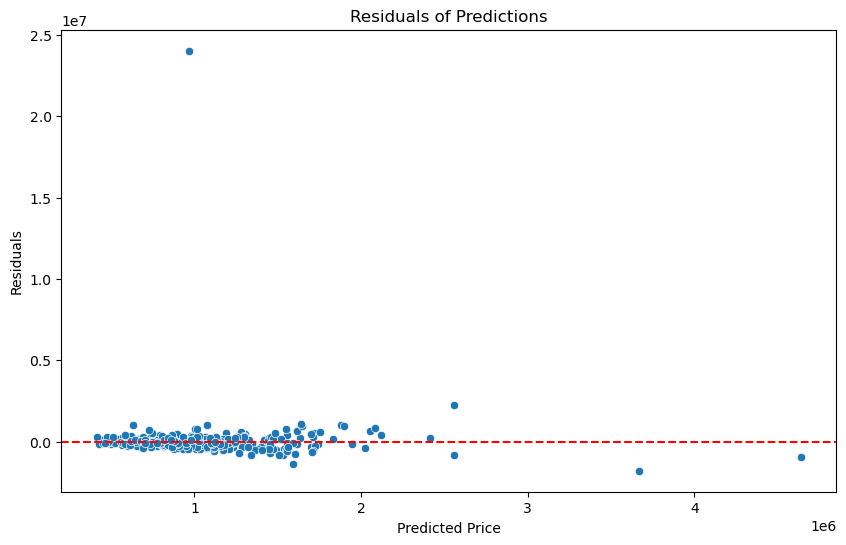

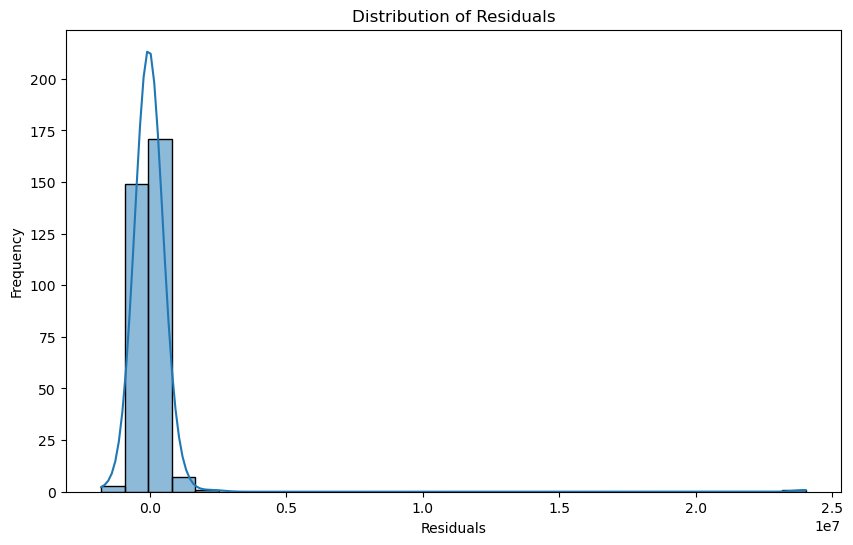

In [89]:
import matplotlib.pyplot as plt
import seaborn as sns

# Ensure matplotlib inline plotting for Jupyter notebooks
%matplotlib inline

# Actual vs. Predicted Prices
plt.figure(figsize=(10, 6))
sns.scatterplot(x=y_test, y=y_pred_refined)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.xlabel('Actual Price')
plt.ylabel('Predicted Price')
plt.title('Actual vs. Predicted Price')
plt.show()

# Residuals Plot
residuals = y_test - y_pred_refined
plt.figure(figsize=(10, 6))
sns.scatterplot(x=y_pred_refined, y=residuals)
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel('Predicted Price')
plt.ylabel('Residuals')
plt.title('Residuals of Predictions')
plt.show()

# Distribution of Residuals
plt.figure(figsize=(10, 6))
sns.histplot(residuals, bins=30, kde=True)
plt.xlabel('Residuals')
plt.ylabel('Frequency')
plt.title('Distribution of Residuals')
plt.show()
